<div style="background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; border: 1px solid #f5c6cb;">
    <strong>!Warning!</strong> Questo è un avviso importante, eseguire la cella sottostante prima di eseguire le altre celle del notebook.
</div>

In [ ]:
# Eseguire prima delle altre celle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from typing import Optional, Union
import librosa
import librosa.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn
import copy
import tqdm
from torch import optim
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import utils
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn import tree
from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from imblearn.over_sampling import SMOTE
# per multi-core processing (intel only)
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Introduzione  

Negli ultimi decenni, il web ha rivoluzionato il modo in cui la musica viene condivisa e fruita. Se un tempo le collezioni musicali erano limitate a una manciata di vinili o CD, oggi gli utenti hanno accesso immediato a vastissimi cataloghi musicali attraverso piattaforme online. Questa crescita esponenziale ha posto nuove sfide, tra cui:  

1. **L'organizzazione automatica delle collezioni musicali**, poiché la gestione manuale non è più sostenibile.  
2. **La raccomandazione automatica di nuove canzoni**, basata sulle preferenze di ascolto dell'utente.  

Un aspetto fondamentale per affrontare queste sfide è la capacità di raggruppare i brani in categorie semantiche, come i **generi musicali**. I generi musicali emergono dall’interazione di fattori culturali, artistici e di mercato e vengono utilizzati per descrivere somiglianze tra brani e organizzare le raccolte musicali. Tuttavia, i confini tra generi non sono sempre ben definiti, rendendo il compito del **riconoscimento automatico del genere musicale (Music Genre Recognition, MGR)** una sfida complessa.  

Nonostante le critiche legate alla soggettività e alla variabilità culturale dei generi musicali, essi rimangono una categorizzazione intuitiva e ampiamente utilizzata dagli utenti per descrivere e scoprire nuova musica. Per questo motivo, il MGR è un tema di grande interesse nella ricerca nel campo del **Music Information Retrieval (MIR)**.  

Il compito affrontato in questo notebook è il **riconoscimento automatico del genere musicale** di un brano a partire esclusivamente dalla sua registrazione audio. Il dataset utilizzato per questo studio è il **FMA (Free Music Archive) dataset**, una raccolta di brani musicali curati e di alta qualità, disponibile pubblicamente per la ricerca. Questo compito è stato anche oggetto di una delle sfide ufficiali della **Web Conference (WWW2018)**.  

L'obiettivo di questo lavoro è esplorare tecniche di **apprendimento automatico** e **elaborazione del segnale audio** per classificare i brani nei rispettivi generi, analizzando le caratteristiche musicali e valutando l'efficacia di diversi modelli predittivi.  


# Dati e dataset

Il dataset **FMA (Free Music Archive)** fornisce un insieme di **feature pre-compute** estratte con la libreria **Librosa**, che descrivono diversi aspetti delle tracce audio e vengono utilizzate per la classificazione automatica del genere musicale.

Abbiamo utilizzato la **versione medium** del dataset, che contiene **25.000 tracce** della durata di **30 secondi**, appartenenti a **16 generi musicali**. Per la classificazione, **non abbiamo estratto nuove feature**, ma abbiamo sfruttato direttamente le feature già disponibili nel dataset.


## Dati Audio
*Un segnale audio consiste in una sequenza di campioni audio, dove
 ogni campione (sample) rappresenta l'ampiezza del suono in un istante 
di tempo specifico. In breve, un segnale audio cattura le variazioni di 
pressione dell'aria nel tempo, che sono percepite dall'orecchio umano 
come suoni.
L'ampiezza di un campione rappresenta l'altezza della forma d'onda 
sonora in quel punto specifico. L'ampiezza è direttamente correlata 
all'intensità del suono. I valori positivi rappresentano le compressioni
 dell'aria (pressione positiva), mentre i valori negativi rappresentano 
le rarefazioni dell'aria (pressione negativa).*

In [ ]:
# audio directory
AUDIO_DIR = os.path.join(os.getcwd(), 'fma_medium')

# metadata directory
METADATA_DIR = os.path.join(os.getcwd(), 'fma_metadata')

In [ ]:
def load_song(genre: str = 'rock', song_number: int = 0) -> tuple[np.ndarray, float]:
    song_title = sorted(os.listdir(os.path.join(AUDIO_DIR, genre)))[song_number]
    song_path = os.path.join(AUDIO_DIR, genre, song_title)
    y, sr = librosa.load(song_path)
    return y, sr

def song_info(y: np.ndarray, sr: float):
    print('y: {}'.format(y))
    print('Duration: {:.2f}s, {} samples, {} KHz'.format(len(y)/sr, len(y), sr/1000))



In [ ]:
def plot_waveplot(y, sr, title='Waveplot', xlabel='Time', ylabel='Amplitude', color=None, alpha=0.8):
    plt.figure(figsize=(14, 5))
    if color:
        librosa.display.waveshow(y, sr=sr, color=color, alpha=alpha)
    else:
        librosa.display.waveshow(y, sr=sr, alpha=alpha)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [ ]:
# load songs
y, sr = load_song('rock', 25)
y2, sr2 = load_song('rock', 112)
y3, sr3 = load_song('classical', 35)

# plot the three songs together vertically

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(y, linewidth=0.5)
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

ax2.plot(y2, linewidth=0.5)
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

ax3.plot(y3, linewidth=0.5)
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels((x_ticks/sr).astype(int))

plt.tight_layout()
plt.show()

### Spettrogramma
È una tecnica di analisi molto comune utilizzata nell'elaborazione dei 
segnali audio per mostrare come l'energia del suono è distribuita nelle 
diverse frequenze durante un periodo di tempo specifico.
L'asse delle ascisse rappresenta il tempo, l'asse delle ordinate 
rappresenta la frequenza e il colore l'ampiezza. Le frequenze più basse si trovano 
nella parte inferiore dello spettrogramma, mentre le frequenze più alte 
si trovano nella parte superiore. La frequenza è solitamente misurata in
 unità come Hertz (Hz).

In [ ]:
def spectrogram(y, mel=False):
    # normalize the amplitude
    y = librosa.util.normalize(y)

    # Short-time Fourier transform (STFT)
    X = librosa.stft(y)

    # Convert an amplitude spectrogram to dB-scaled spectrogram.
    x_db = librosa.amplitude_to_db(abs(X))

    # Display a spectrogram
    plt.figure(figsize=(14, 5))
    if mel:
        # Mel-scaled power spectrogram
        X_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        x_db_mel = librosa.amplitude_to_db(abs(X_mel), ref=np.max)

        plt.figure(figsize=(14, 10))

        plt.subplot(2, 1, 1)
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Simple Spectrogram')
        plt.colorbar()

        plt.subplot(2, 1, 2)
        librosa.display.specshow(x_db_mel, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Mel-scaled spectrogram')
        plt.colorbar()
        plt.tight_layout()
    else:
        librosa.display.specshow(x_db, sr=sr, x_axis='time', y_axis='hz')
        plt.title('Spectrogram')
        plt.colorbar()

    plt.show()

In [ ]:
spectrogram(y, True)

## Feature contenute nel dataset

Le feature fornite rappresentano caratteristiche **timbriche, tonali e spettro-temporali** del segnale audio. Sono state calcolate su finestre di **2048 campioni**, con un **hop size di 512 campioni**, e per ciascuna di esse sono state estratte sette statistiche principali: **media, deviazione standard, asimmetria (skewness), curtosi, mediana, minimo e massimo**.

Di seguito le principali feature disponibili:

- **MFCC (Mel-Frequency Cepstral Coefficients) [140 dimensioni]**: rappresentano il timbro del suono e sono molto utilizzati nell'elaborazione audio.
- **Chroma Features [252 dimensioni]**: descrivono la distribuzione delle frequenze nella scala musicale, utili per analizzare tonalità e armonie.
- **Tonnetz Features [42 dimensioni]**: catturano la struttura armonica del brano e le relazioni tonali.
- **Spectral Centroid [7 dimensioni]**: indica il "centro di massa" dello spettro di frequenza, utile per distinguere tra suoni acuti e gravi.
- **Spectral Bandwidth [7 dimensioni]**: misura la dispersione delle frequenze attorno al centroide.
- **Spectral Contrast [49 dimensioni]**: quantifica la differenza tra le parti più intense e meno intense dello spettro.
- **Spectral Rolloff [7 dimensioni]**: identifica la frequenza sotto la quale si trova il **95% dell'energia spettrale**.
- **RMS Energy (Root Mean Square Energy) [7 dimensioni]**: misura l'energia complessiva del segnale, utile per analizzare il volume medio del brano.
- **Zero-Crossing Rate [7 dimensioni]**: conta il numero di volte in cui il segnale attraversa lo zero, utile per distinguere suoni percussivi da quelli armonici.

Queste informazioni sono memorizzate nel file **features.csv**, dove ogni riga rappresenta una traccia e ogni colonna una delle feature estratte.

Segue ora una descrizione più approfondita di alcune delle feature utilizzate.

### Zero Crossing Rate
Viene utilizzata per calcolare il tasso di attraversamento dello zero in
 un segnale audio. Il tasso di attraversamento dello zero rappresenta il
 numero di volte in cui la forma d'onda di un segnale attraversa l'asse 
orizzontale (zero) in un determinato intervallo di tempo.

In [ ]:
def plot_zero_cross_rate(y1, y2, label1, label2, zero_line=True):

    # zero crossing rate
    z1 = librosa.feature.zero_crossing_rate(y1)
    z2 = librosa.feature.zero_crossing_rate(y2)


    # plot a graph with the two crossing rates, and one with the difference between the tww (horizontally)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    fig.suptitle('Zero Crossing Rate', fontsize=16)

    # left plot
    ax1.plot(z1[0], label=label1, linewidth=.5)
    ax1.plot(z2[0], label=label2, linewidth=.5)

    # mean line
    m1 = np.mean(z1)
    m2 = np.mean(z2)
    ax1.axhline(m1, color='blue', linestyle='--', linewidth=2, label=f'Mean of {label1}')
    ax1.axhline(m2, color='red', linestyle='--', linewidth=2, label=f'Mean of {label2}')

    # right plot
    z3 = z1 - z2
    ax2.plot(z3[0], color='green', label='Difference', linewidth=.5)
    ax2.set_title('Difference between the two crossing rates')

    # mean line
    m3 = np.mean(z3)
    ax2.axhline(m3, color='purple', linestyle='--', linewidth=2, label=f'Mean of the difference')

    if zero_line:
        ax1.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax1.set_title('Zero Crossing Rate')
        ax2.set_title('Zero Crossing Rate')

    ax1.legend()
    ax2.legend()

    plt.show()

In [ ]:
plot_zero_cross_rate(y, y3, 'Rock Song 1', 'Classical Song')
plot_zero_cross_rate(y, y2, 'Rock Song 1', 'Rock Song 2')

### RMS Energy
La ***Root Mean Square Energy*** è una misura dell'energia complessiva o della sonorità del segnale nel tempo. Fornisce informazioni sulle variazioni di ampiezza del segnale audio.

In [ ]:
# Calculate RMS energy
rms1 = librosa.feature.rms(y=y)
rms2 = librosa.feature.rms(y=y2)
rms3 = librosa.feature.rms(y=y3)

times = librosa.times_like(rms1)

# Plot RMS energy
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# librosa.display.waveshow(y, sr=sr)
ax1.plot(times, rms1[0])
ax1.set_title('Rock Song 1')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMS Energy')

ax2.plot(times, rms2[0])
ax2.set_title('Rock Song 2')
ax2.set_xlabel('Time')
ax2.set_ylabel('RMS Energy')

ax3.plot(times, rms3[0])
ax3.set_title('Classical Song')
ax3.set_xlabel('Time')
ax3.set_ylabel('RMS Energy')

# set x ticks to seconds, every 5 seconds starting from 0
x_ticks = np.arange(0, len(y), sr*5)

plt.tight_layout()
plt.show()

### Mel-Frequency Cepstral Coefficients
Sono una serie di coefficienti utilizzati per rappresentare le caratteristiche spettrali di un segnale audio in un formato compatibile con la percezione umana delle frequenze (vengono utilizzati soprettutto per il riconoscimento e la sintesi vocale).
Per essere più precisi, i coefficienti MFCC rappresentano una serie di valori numerici che catturano le caratteristiche spettrali del segnale audio in un dato frame temporale.
Ad esempio, nella cella (1,2) troveremo il valore del terzo coefficiente di mel nel secondo frame.

In [ ]:
def plot_mfcc(*Y, sr, songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)
    fig.suptitle('Mel-frequency cepstral coefficients (MFCC)', fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):

        # mfcc of the song
        mfcc = librosa.feature.mfcc(y=Y[i], sr=sr)

        mean = np.mean(mfcc)
        variance = np.var(mfcc)

        # scale the mfcc
        mfcc = skl.preprocessing.scale(mfcc, axis=1)

        # display the mfcc
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax[i])

        # set title
        title = songs_names[i] if songs_names else f'Song {i+1}'
        ax[i].set_title(f'{title}\nMean: {mean:.2f}, Variance: {variance:.2f}')

        # set x and y labels
        ax[i].set_xlabel(None)
        ax[i].set_ylabel('MFCC')

    ax[-1].set_xlabel('Time')

    plt.show()

In [ ]:
plot_mfcc(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Spectral centroid
è una misura del 'centro di massa' dello spettro. Indica dove si trova 
il 'centro' del suono in termini di frequenza. Percettivamente, è 
strettamente correlato alla sensazione di 'brillantezza' di un suono.

In [ ]:
def normalize(x, axis=0):

    return skl.preprocessing.minmax_scale(x, axis=axis)

def plot_spectral_centroid(*Y, sr, title='Spectral Centroid', xlabel='Time', ylabel='Frequency', songs_names=None):

    n = len(Y)
    fig, ax = plt.subplots(n, 1, figsize=(14, 5*n), sharex=True)

    fig.suptitle(title, fontsize=16)

    if n == 1:
        ax = [ax]

    for i in range(n):
        y = Y[i]

        # Computing the spectral centroid for each frame
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

        # Computing the time variable for visualization
        frames = range(len(cent))

        # Converts frame counts to time (seconds)
        t = librosa.frames_to_time(frames)

        librosa.display.waveshow(y, sr=sr, linewidth=.5,  alpha=0.4, ax=ax[i])
        ax[i].plot(t, normalize(cent), color='#FFB100', label='Spectral Centroid', linewidth=2)

        title = songs_names[i] if songs_names else f'Song {i+1}'

        ax[i].set_title(title)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [ ]:
plot_spectral_centroid(y, y2, y3, sr=sr, songs_names=['Rock Song 1', 'Rock Song 2', 'Classical Song'])

### Chroma Features
Le Chroma Features, sono strumenti utili ad analizzare il contenuto armonico e tonale della musica. Sono particolarmente utili per compiti che coinvolgono 
l'analisi del tono e dell'armonia, come il riconoscimento degli accordi, il rilevamento della tonalità e la stima della somiglianza musicale.

Le Chroma features rappresentano l'intensità di ciascuna delle 12 classi di tonalità (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) nel segnale audio, indipendentemente dall'ottava. Questo le rende particolarmente adatte per l'analisi delle caratteristiche armoniche e melodiche della musica.

Concetti chiave:

- **classe di tonalità**: tutte le tonalità che condividono la stessa nota (ad esempio, tutte le note C nelle diverse ottave);
- **"Invarianza d'ottava**: le caratteristiche sommano l'energia su tutte le ottave per ciascuna classe di note.

In [ ]:
# Compute chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Visualize chroma features
plt.figure(figsize=(14, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()

## Motivazione delle scelte

Per ottenere una rappresentazione più efficace dei dati, avremmo potuto utilizzare degli **autoencoder**, una classe di reti neurali progettate per apprendere una rappresentazione compressa e significativa degli input. Gli autoencoder avrebbero potuto estrarre caratteristiche più astratte e strutturate dai dati audio, migliorando potenzialmente la classificazione dei generi musicali.

Tuttavia, il **formato audio** è complesso da gestire e richiede tecniche avanzate di elaborazione del segnale, come la conversione in spettrogrammi o l'uso di architetture specializzate per sequenze temporali, come le **RNN (Reti Neurali Ricorrenti)** o i **Transformer**. Poiché a lezione non abbiamo affrontato modelli per la gestione di **sequenze di dati**, abbiamo preferito evitare questa strada e concentrarci sull'utilizzo delle feature pre-estratte, già fornite nel dataset.

L'obiettivo del nostro lavoro è stato quindi analizzare e confrontare diverse tecniche di **machine learning**, valutando le performance ottenute con le feature disponibili.

# Analisi esplorativa

Innanzi tutto osserviamo che il nostro dataset conta un totale di 25000 osservazioni e 518 feature. Ad ognuna di esse è associato un genere target.

In [3]:
X = utils.load('./fma_metadata/features_medium.csv')
y = pd.read_csv('./fma_metadata/train_labels.csv', index_col=0)

np.testing.assert_array_equal(X.index, y.index)

X.shape, y.shape

((25000, 518), (25000, 1))

Verifichiamo ora quante occorrenze sono presenti nel nostro dataset

In [4]:
CATEGORIES = sorted(y["genre"].unique())

y.groupby('genre').size()

genre
blues                    74
classical               619
country                 178
easy listening           21
electronic             6314
experimental           2251
folk                   1519
hip-hop                2201
instrumental           1350
international          1018
jazz                    384
old-time / historic     510
pop                    1186
rock                   7103
soul-rnb                154
spoken                  118
dtype: int64

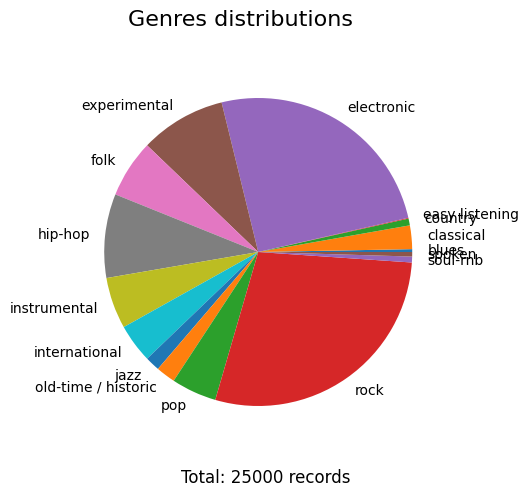

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), facecolor='white')
fig.suptitle('Genres distributions', fontsize=16)

# plot a bar chart of genres
ax.pie(y.groupby('genre').size(), labels=CATEGORIES)
ax.text(-.5, -1.5, 'Total: {} records'.format(len(y)), fontsize=12)

plt.show()

Si evince quindi che il dataset è molto sbilanciato, con classi che contano migliaia di osservazioni e classi che ne contano poche decine. Segue poi un pò di data cleaning per assicurarci che tutti i dati siano nel giusto formato e non siano presenti valori strani.

In [6]:
%%capture

# Data cleaning
X = X.drop(utils.FILES_TRAIN_FAULTY)
y = y.drop(utils.FILES_TRAIN_FAULTY)

# The track IDs are integers for the training set.
X.index = pd.Index((int(i) for i in X.index), name='track_id')

# Should be done already, but better be sure.
X.sort_index(inplace=True)
y.sort_index(inplace=True)

# Data normalization
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X)

In [22]:
# feature selection tests
from sklearn.feature_selection import SelectKBest, mutual_info_classif

fs = SelectKBest(mutual_info_classif, k=200).fit(X, y)

X_new = pd.DataFrame(fs.transform(X))

In [23]:
# split X_new
X_new_train, X_new_test, y_new_train, y_new_test = split_dataset(X_new,y,test_size=0.2,random_state=42)
X_new_test, X_new_val, y_new_test, y_new_val = split_dataset(X_new_test, y_new_test, test_size=0.5, random_state=42)

X_new_train, y_new_train = skl.utils.shuffle(X_new_train, y_new_train, random_state=42)

Abbiamo poi eseguito un'analisi della **correlazione** tra le diverse feature del dataset per identificare eventuali relazioni lineari tra di esse. Questo ci ha permesso di capire meglio la struttura del dataset e di individuare feature ridondanti che potrebbero influire sulla performance dei modelli di machine learning.

Osserva che questa analisi è isolata alle sole "medie" delle varie feature.

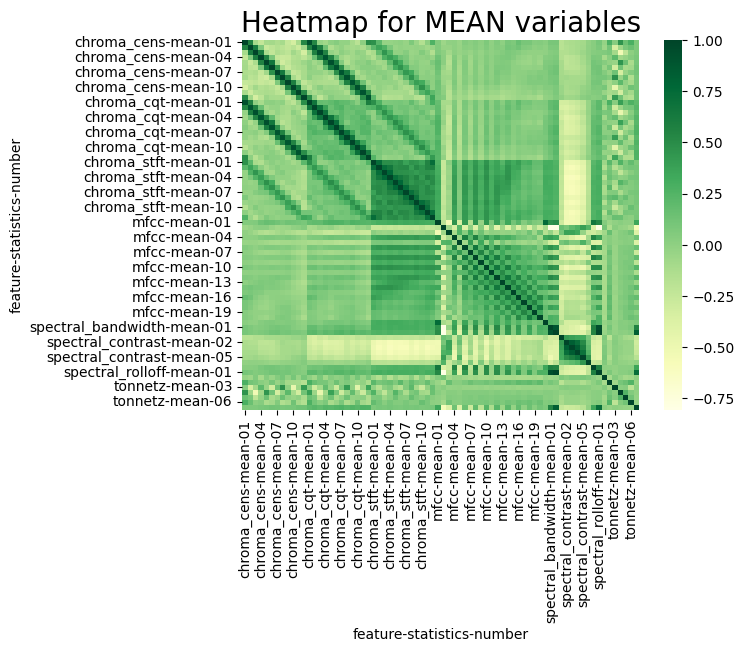

In [9]:
spike_cols = [col for col in X.columns if 'mean' in col] 
sns.heatmap(X[spike_cols].corr(), cmap='YlGn') 

plt.title('Heatmap for MEAN variables', fontsize = 20) 
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10);
plt.show()

Nel'heatmap si possono notare dei blocchi di colore omogeneo. Quelli centrati sulla diagonale mettono in evidenza un'osservazione che ci saremmo potuti immaginare anche senza mappa: le stesse misurazioni fatte con parametri diversi (per esempio chroma_stft_10, chroma_stft_07...) sono altamente correlate tra di loro. Osserviamo però che blocchi omogenei sono presenti anche lontani dalla diagonale, questi mettono in evidenza della correlazione anche tra metriche diverse! Queste correlazioni possono essere sfruttate per ridurre la dimensionalità.

## Selezione delle feature più rilevanti

Successivamente, abbiamo applicato la **PCA (Principal Component Analysis)** per ridurre la dimensionalità del dataset. Questa tecnica ci ha permesso di comprimere le informazioni contenute nelle feature originali in un numero inferiore di componenti principali, preservando la maggior parte della varianza nei dati. La riduzione della dimensionalità è stata utile per semplificare il modello, migliorare l'efficienza computazionale e, in alcuni casi, ridurre il rischio di overfitting.

Il grafico sotto mostra che il 90% varianza del dataset è catturata da meno di 150 componenti.

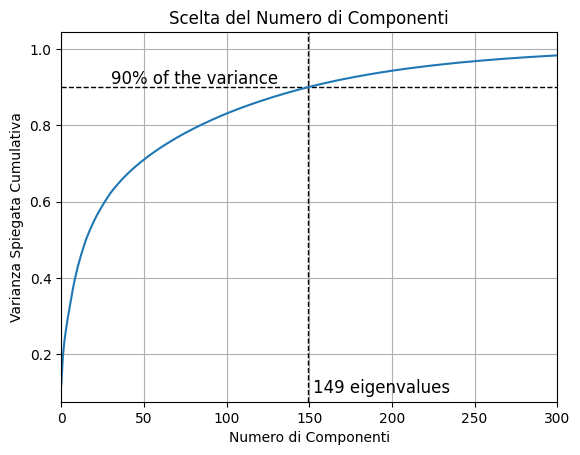

In [10]:
pca = PCA().fit(X)  # PCA senza specificare componenti

cumsum = np.cumsum(pca.explained_variance_ratio_)
idx = np.argmin(np.abs(cumsum - cumsum[-1]*.90))

# plot the eigenvalues horizontal line that represents the 95% of the variance
plt.axhline(cumsum[idx], color='black', linestyle='--', linewidth=1)
plt.text(30, cumsum[idx]+0.01, '90% of the variance', fontsize=12)

# plot the eigenvalues vertical line that represents the number of eigenvalues that represents the 95% of the variance
plt.axvline(idx, color='black', linestyle='--', linewidth=1)
plt.text(idx+3, 0.1, f'{idx} eigenvalues', fontsize=12)

plt.xlim(0, 300)
plt.plot(cumsum)
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()

Allora durante l'analisi dei modelli verrà considerato il dataset in tre forme:

- forma originale;
- proiettato nel sottospazio generato dagli autovettori associati ai primi 63 autovalori (75% della varianza del dataset);
- proiettato nel sottospazio generato dagli autovettori associati ai primi 149 autovalori (90% della varianza del dataset);

In [11]:
def split_dataset(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.3, random_state: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train, test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return train, test, y_train, y_test


In [12]:
def smote(x_train, y_train) -> tuple:
    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)
    return x_train_balanced, y_train_balanced


In [13]:
X_train, X_test, y_train, y_test = split_dataset(X,y,test_size=0.2,random_state=42)
X_test, X_val, y_test, y_val = split_dataset(X_test, y_test, test_size=0.5, random_state=42)

# X_train, y_train = smote(X_train, y_train)

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

print("Forma originale:", X_train.shape)
percent = [.90, .75]

X_trains = []
X_tests = []

X_trains.append(X_train)
X_tests.append(X_test)

for p in percent:
    d = np.argmin(np.abs(cumsum - cumsum[-1]*p))
    pca = PCA(n_components=d)
    pca.fit(X)
    X_trains.append(pd.DataFrame(pca.transform(X_train)))
    X_tests.append(pd.DataFrame(pca.transform(X_test)))

for x in X_trains[1:]:
    print("Dopo PCA", x.shape)

pca = PCA(n_components=149)
pca.fit(X)
X_val = pd.DataFrame(pca.transform(X_val))
y_train.groupby('genre').size()

Forma originale: (19983, 518)
Dopo PCA (19983, 149)
Dopo PCA (19983, 63)


genre
blues                    56
classical               490
country                 148
easy listening           15
electronic             5047
experimental           1803
folk                   1200
hip-hop                1754
instrumental           1065
international           819
jazz                    296
old-time / historic     414
pop                     964
rock                   5704
soul-rnb                119
spoken                   89
dtype: int64

Vediamo ora quali sono le feature che abbiamo selezionato e "quanta" varianza spiegano.

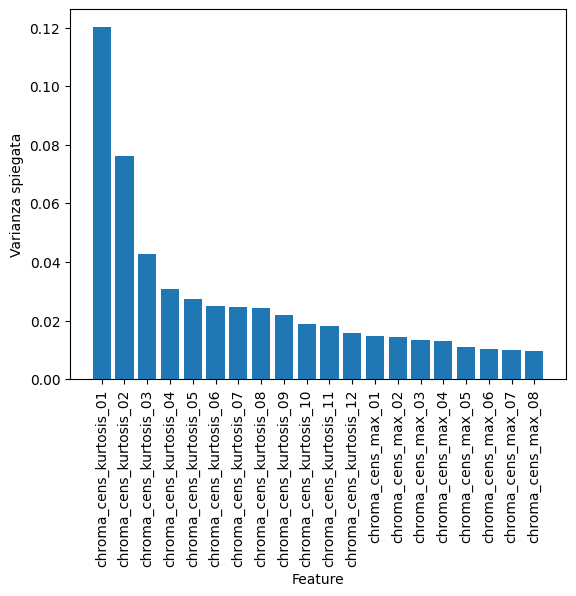

In [14]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:20]
pca_feature_importance_keys = [feature for (feature, value) in pca_feature_importance]
pca_feature_importance_value = [value for (feature, value) in pca_feature_importance]

fig, ax = plt.subplots()

# Creazione del bar chart
ax.bar(pca_feature_importance_keys ,pca_feature_importance_value)

# Aggiungere etichette e titolo
ax.set_xlabel('Feature')
ax.set_ylabel('Varianza spiegata')
plt.xticks(rotation=90)

# Mostrare il grafico
plt.show()

# Modelli
Per affrontare il compito di classificazione del genere musicale sul dataset **FMA (Free Music Archive)**, sono stati testati diversi modelli di machine learning al fine di confrontarne le performance e identificare l'approccio più efficace. Ogni modello scelto rappresenta una tecnica classica o avanzata di classificazione, in grado di gestire il tipo di dati e le feature pre-estratte dal dataset.

I modelli implementati comprendono:

- **LSTM** (Baseline model) 
- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**

Questi modelli sono stati scelti per sfruttare diversi approcci al machine learning, esplorando tanto metodi parametrici quanto non-parametrici.

Per ogni modello che sperimentiamo riportiamo la matrice di confusione e le metriche più importanti (Guarda cella sotto).

Le definizione delle metriche che abbiamo analizzato sono riportate qui:

### Metriche di valutazione

$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$

$$
\text{F1-score}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$

### Medie delle metriche

$$
\text{Macro Precision} = \frac{1}{N} \sum_{i=1}^{N} \text{Precision}_i
$$

$$
\text{Macro Recall} = \frac{1}{N} \sum_{i=1}^{N} \text{Recall}_i
$$

$$
\text{Macro F1-score} = \frac{1}{N} \sum_{i=1}^{N} \text{F1-score}_i
$$

**Weighted Average**  
(calcolata pesando ogni classe in base alla sua frequenza):

$$
\text{Weighted Precision} = \sum_{i=1}^{N} w_i \cdot \text{Precision}_i
$$

$$
\text{Weighted Recall} = \sum_{i=1}^{N} w_i \cdot \text{Recall}_i
$$

$$
\text{Weighted F1-score} = \sum_{i=1}^{N} w_i \cdot \text{F1-score}_i
$$

Dove:
- \( TP_i \) = True Positives per la classe \( i \)
- \( FP_i \) = False Positives per la classe \( i \)
- \( FN_i \) = False Negatives per la classe \( i \)
- \( N \) è il numero di classi
- \( w_i \) è il peso della classe \( i \), definito come la proporzione di campioni appartenenti a quella classe rispetto al totale.





In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test, title = 'Confusion matrix'):
    y_pred = clf.predict(x_test)
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title=title)    
    print(classification_report(y_test, y_pred))


# LSTM

In [1]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Parametri audio
SAMPLE_RATE = 22050  # Frequenza di campionamento standard
DURATION = 30  # Durata dei file audio (in secondi)
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION  # Numero totale di campioni per traccia

# Caricare i dati audio e normalizzarli
def load_audio(file_path, max_length=SAMPLES_PER_TRACK):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(signal) > max_length:
        signal = signal[:max_length]  # Troncatura
    elif len(signal) < max_length:
        signal = np.pad(signal, (0, max_length - len(signal)), mode='constant')  # Padding
    return signal

# Percorso dei file audio
data_dir = "./fma_small/"
genres = os.listdir(data_dir)
X, y = [], []

for genre in genres:
    genre_path = os.path.join(data_dir, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".mp3"):
                file_path = os.path.join(genre_path, file)
                signal = load_audio(file_path)
                X.append(signal)
                y.append(genre)

# Convertire le feature in array numpy
X = np.array(X)
y = np.array(y)

# Convertire le label in numeri
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione del Dataset personalizzato
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Creazione dei DataLoader
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definizione del modello LSTM
class LSTMAudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMAudioClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Istanziamento del modello
input_size = 1
hidden_size = 128
num_classes = 16
model = LSTMAudioClassifier(input_size, hidden_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definizione della funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training del modello
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Valutazione del modello
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: './fma_small/'

# Support Vector Machine for classification

Il primo modello che abbiamo utilizzato è la Support Vector Machine appositamente adattata per i task di classificazione. Nello specifico, abbiamo usato la funzione kernel *Radial Basis Function* (RBF), visto che ha la caratteristica peculiare di far aumentare la distanza dagli altri punti in modo esponenziale.

In [17]:
def svm(
    X_train, y_train, X_test, y_test,
    title: str = 'SVM',
    kernel: str = 'rbf',
    degree: int = 3,
    C: float = 1.0,
    gamma : Union[float, str] = 'scale'):

    # create the model
    model = sklearn.svm.SVC(kernel="rbf", gamma=gamma, C=C, degree=degree)

    # train the model
    model.fit(X_train, y_train)
    valuate(model, X_test, y_test, title=title)

    return model

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.81      0.90      0.85        77
            country       0.00      0.00      0.00        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.65      0.82      0.73       606
       experimental       0.51      0.53      0.52       226
               folk       0.61      0.66      0.63       152
            hip-hop       0.72      0.60      0.66       223
       instrumental       0.54      0.41      0.46       137
      international       0.70      0.42      0.53       104
               jazz       0.68      0.41      0.52        41
old-time / historic       0.98      0.96      0.97        45
                pop       0.41      0.06      0.10       126
               rock       0.74      0.86      0.79       699
           soul-rnb       0.00      0.00      0.00        19
             spoken    

SVC()

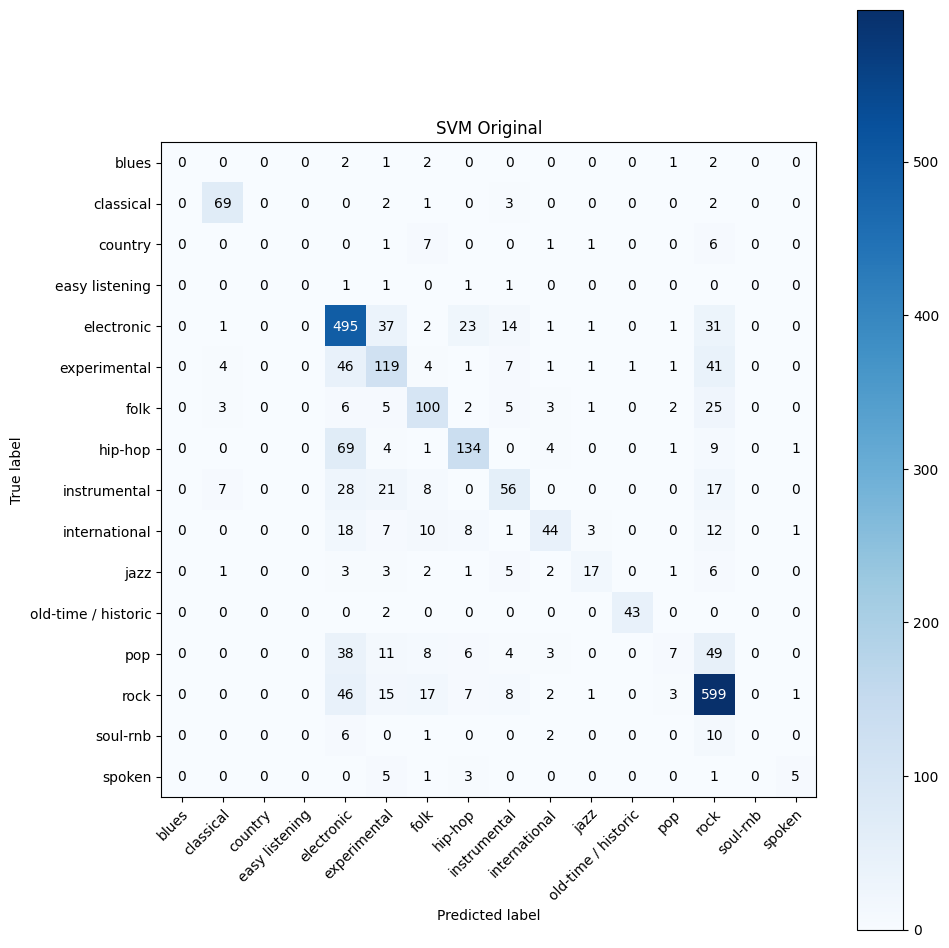

In [18]:
svm(X_trains[0], y_train, X_tests[0], y_test, title="SVM Original")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.81      0.87      0.84        77
            country       0.00      0.00      0.00        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.64      0.82      0.72       606
       experimental       0.52      0.50      0.51       226
               folk       0.61      0.62      0.61       152
            hip-hop       0.72      0.59      0.65       223
       instrumental       0.51      0.40      0.45       137
      international       0.70      0.40      0.51       104
               jazz       0.64      0.39      0.48        41
old-time / historic       0.96      0.96      0.96        45
                pop       0.29      0.03      0.06       126
               rock       0.72      0.86      0.78       699
           soul-rnb       0.00      0.00      0.00        19
             spoken    

SVC()

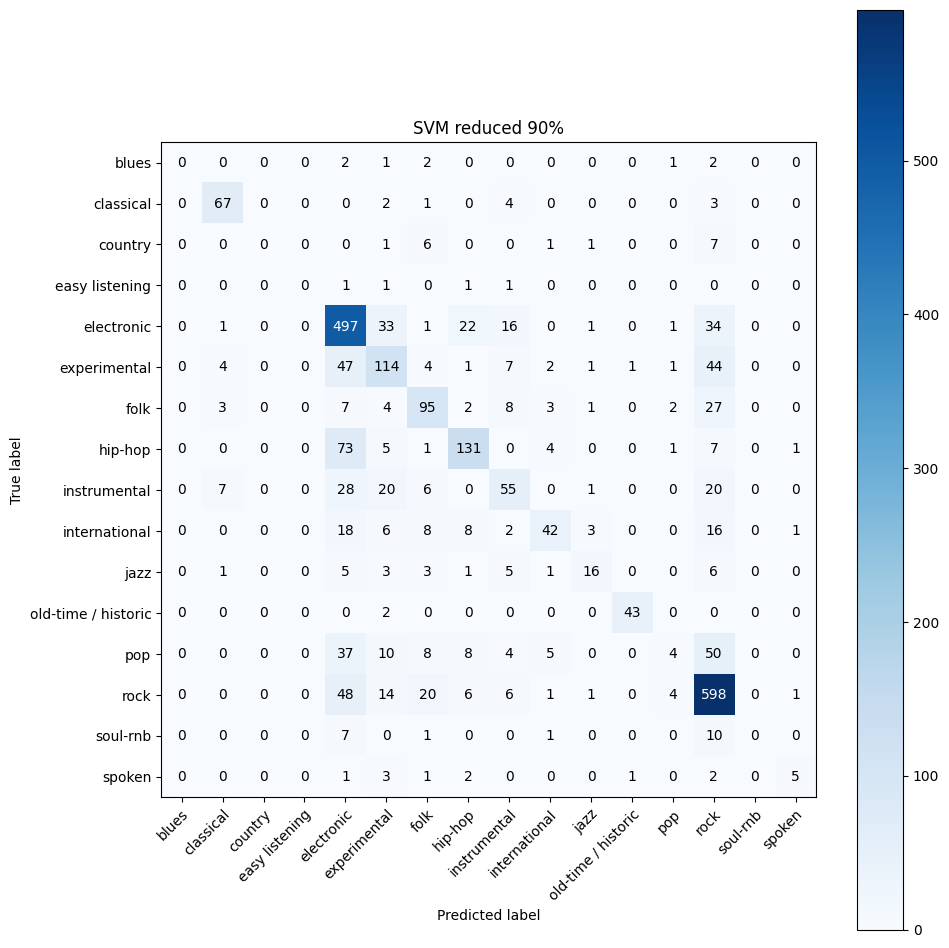

In [19]:
svm(X_trains[1], y_train, X_tests[1], y_test, title="SVM reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.78      0.87      0.82        77
            country       0.00      0.00      0.00        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.64      0.81      0.71       606
       experimental       0.52      0.48      0.50       226
               folk       0.58      0.62      0.60       152
            hip-hop       0.68      0.57      0.62       223
       instrumental       0.51      0.39      0.45       137
      international       0.65      0.38      0.48       104
               jazz       0.59      0.32      0.41        41
old-time / historic       0.94      0.98      0.96        45
                pop       0.29      0.02      0.03       126
               rock       0.72      0.86      0.79       699
           soul-rnb       0.00      0.00      0.00        19
             spoken    

SVC()

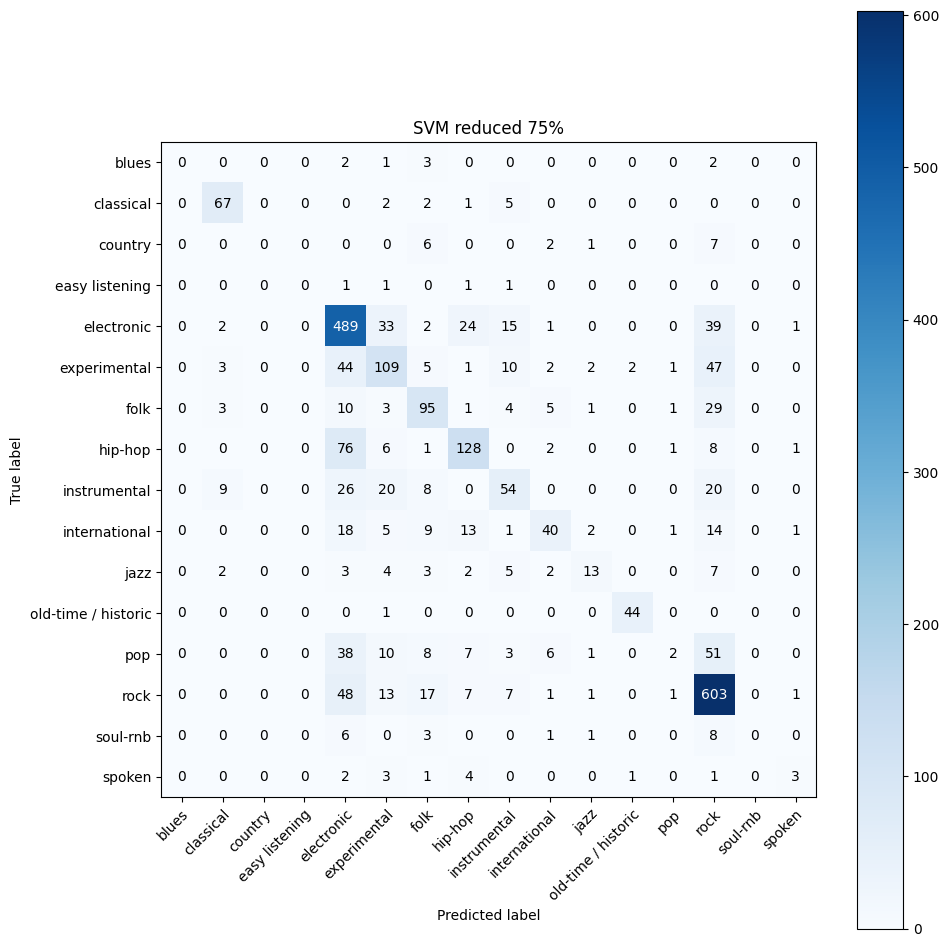

In [20]:
svm(X_trains[2], y_train, X_tests[2], y_test, title="SVM reduced 75%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.84      0.87      0.85        77
            country       1.00      0.06      0.12        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.65      0.83      0.73       606
       experimental       0.51      0.51      0.51       226
               folk       0.65      0.67      0.66       152
            hip-hop       0.77      0.59      0.67       223
       instrumental       0.56      0.45      0.50       137
      international       0.72      0.48      0.58       104
               jazz       0.67      0.29      0.41        41
old-time / historic       0.95      0.93      0.94        45
                pop       0.55      0.10      0.16       126
               rock       0.74      0.86      0.79       699
           soul-rnb       0.00      0.00      0.00        19
             spoken    

SVC()

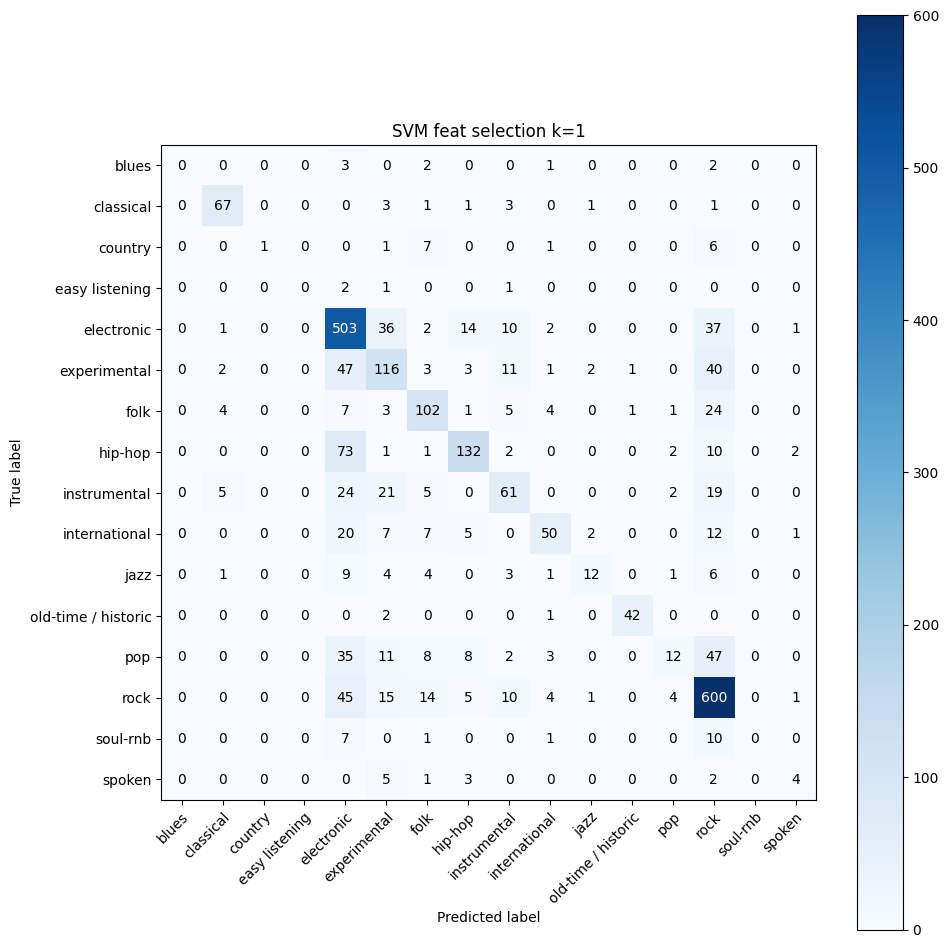

In [24]:
# feature selection tests
svm(X_new_train, y_new_train, X_new_test, y_new_test, title="SVM feat selection k=1")

### Learn best C

In [22]:
# hyperparameter C tuning
c_range = np.logspace(-2, 4, 5)
print(c_range)


[1.00000000e-02 3.16227766e-01 1.00000000e+01 3.16227766e+02
 1.00000000e+04]


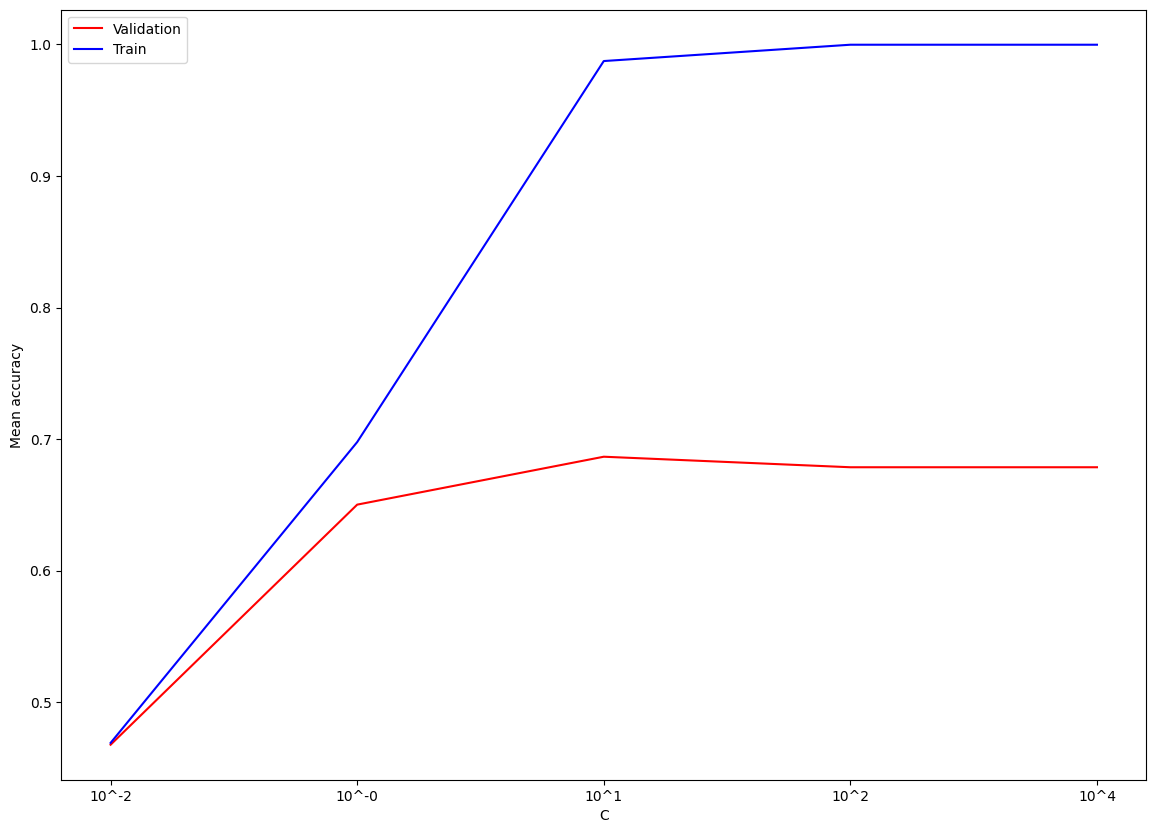

In [23]:
c_results = []
for c in c_range:
    model = svm(X_trains[1], y_train, X_val, y_val, C=c)
    c_results.append({
        'c': c,
        'score': model.score(X_val.values, y_val.values),
        'score_train': model.score(X_trains[1].values, y_train.values)
    })

plt.figure(figsize=(14, 10))
plt.plot(list(map(lambda x: x['score'], c_results)), label='Validation', color='red')
plt.plot(list(map(lambda x: x['score_train'], c_results)), label='Train', color='blue')
plt.legend()
# plt.xticks(ticks=range(len(c_range)), labels=[f"{c:.2f}" for c in c_range])
plt.xticks(ticks=range(len(c_range)), labels=[f"10^{np.log10(c):.0f}" for c in c_range])
plt.ylabel('Mean accuracy')
plt.xlabel('C')
plt.show()

### Learn best gamma

In [ ]:
# hyperparameter gamma tuning
gamma_range = np.logspace(-5, 1, 5)

print(gamma_range)

In [ ]:
# hyperparameter gamma tuning
gamma_range = np.logspace(-15, 1, 13)

gamma_results = []
for gamma in gamma_range:
    model = svm(X_trains[1], y_train, X_val, y_val, gamma=gamma)
    gamma_results.append({
        'gamma': gamma,
        'score': model.score(X_val.values, y_val.values),
        'score_train': model.score(X_trains[1].values, y_train.values)
    })

plt.figure(figsize=(14, 10))
plt.plot(list(map(lambda x: x['score'], gamma_results)), label='Validation', color='red')
plt.plot(list(map(lambda x: x['score_train'], gamma_results)), label='Train', color='blue')
plt.legend()
plt.xticks(ticks=range(len(gamma_range)), labels=[f"10^{np.log10(gamma):.0f}" for gamma in gamma_range])
plt.ylabel('Mean accuracy')
plt.xlabel('$\gamma$')
plt.title('RBF SVM - 30 seconds of audio')
plt.show()

### GridSearchCV SVM

In [25]:
# modified: using dataset with feature selection applied for testing
model = skl.svm.SVC()

param_grid = {
    'C': np.logspace(-2, 3, 5),          # Parametro di regolarizzazione
    'kernel': ['rbf'],    # Tipo di kernel
    'gamma': np.logspace(-5, -1, 7)  # Coefficiente del kernel (solo per kernel 'rbf')
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_new_train, y_new_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_new_test, y_new_test)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'C': np.float64(3.1622776601683795), 'gamma': np.float64(0.004641588833612777), 'kernel': 'rbf'}
Accuracy del modello ottimizzato: 0.7017614091273019


                     precision    recall  f1-score   support

              blues       1.00      0.25      0.40         8
          classical       0.82      0.91      0.86        77
            country       0.67      0.12      0.21        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.69      0.82      0.75       606
       experimental       0.50      0.50      0.50       226
               folk       0.65      0.70      0.67       152
            hip-hop       0.76      0.66      0.71       223
       instrumental       0.58      0.45      0.51       137
      international       0.79      0.52      0.63       104
               jazz       0.78      0.61      0.68        41
old-time / historic       0.96      0.96      0.96        45
                pop       0.53      0.18      0.27       126
               rock       0.75      0.86      0.80       699
           soul-rnb       1.00      0.21      0.35        19
             spoken    

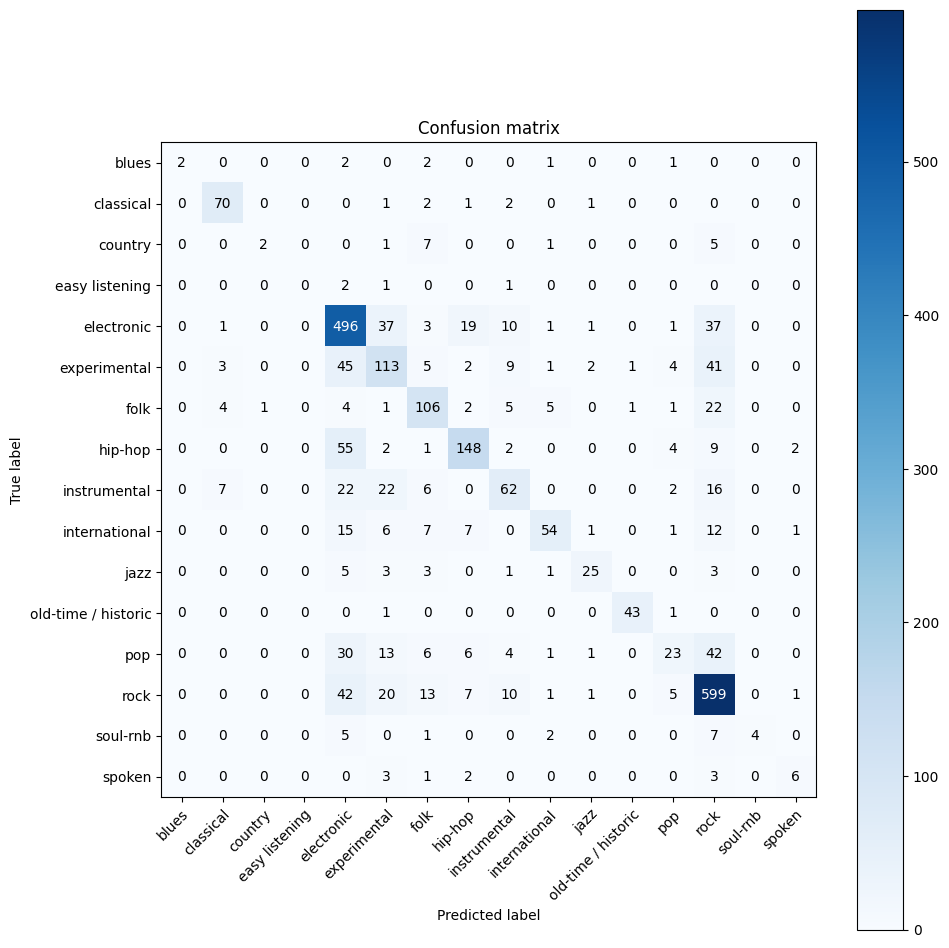

In [27]:
valuate(best_model, X_new_test, y_test)

# Tree-based models

In questa sezione esploriamo i modelli basati su strutture ad albero:
- Decision Tree
- Bagging
- Random Forest
- AdaBoost
- XGBoost

Per ogni modello proponiamo una specifica configurazione dei meta-parametri e poi esploriamo le sue performance al variare di questi.

## Decision Tree

In questo caso fissiamo *max_depth*=10.


In [ ]:
maxdepth=10
def tree_clf(X_train, y_train, X_test, y_test, criterion = 'gini', maxdepth = 10, title: str = 'Decision Tree'):

    # create the model
    model = tree.DecisionTreeClassifier(max_depth=maxdepth, class_weight='balanced')

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)


In [ ]:
tree_clf(X_trains[0], y_train, X_tests[0], y_test, maxdepth=maxdepth, title="DecTree Original")

In [ ]:
tree_clf(X_trains[1], y_train, X_tests[1], y_test, maxdepth=maxdepth, title="DecTree Reduced 90%")

In [ ]:
tree_clf(X_trains[2], y_train, X_tests[2], y_test, maxdepth=maxdepth, title="DecTree Reduced 75%")

### Learn max_depth

Di seguito, invece, facciamo variare il parametri delle *max_depth* con i valori nel range (1,32). Dal grafico in basso, si vede che le massime prestazioni si ottengono con un altezza pari a 25.

In [26]:
X_train, X_test = X_train[1], X_test[1]
max_depth_range = np.linspace(1, 32, 32, endpoint=True).astype(int)

# Liste per raccogliere le metriche
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

# Loop per testare diversi valori di max_depth
for n in max_depth_range:
    model = tree.DecisionTreeClassifier(max_depth=n, criterion='gini', splitter='best')
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    train_accuracies.append(acc_train)
    train_f1_scores.append(f1_train)
    test_accuracies.append(acc_test)
    test_f1_scores.append(f1_test)

    print(f"max_depth={n}: Accuracy={acc_test:.4f}, F1_weighted={f1_test:.4f}")



max_depth=1: Accuracy=0.3995, F1_weighted=0.2835
max_depth=2: Accuracy=0.3995, F1_weighted=0.2835
max_depth=3: Accuracy=0.4275, F1_weighted=0.3551
max_depth=4: Accuracy=0.4628, F1_weighted=0.3988
max_depth=5: Accuracy=0.4940, F1_weighted=0.4580
max_depth=6: Accuracy=0.5008, F1_weighted=0.4592
max_depth=7: Accuracy=0.5100, F1_weighted=0.4689
max_depth=8: Accuracy=0.5140, F1_weighted=0.4835
max_depth=9: Accuracy=0.5216, F1_weighted=0.4912
max_depth=10: Accuracy=0.5084, F1_weighted=0.4861
max_depth=11: Accuracy=0.5104, F1_weighted=0.4860
max_depth=12: Accuracy=0.5048, F1_weighted=0.4871
max_depth=13: Accuracy=0.5004, F1_weighted=0.4863
max_depth=14: Accuracy=0.4920, F1_weighted=0.4820
max_depth=15: Accuracy=0.4848, F1_weighted=0.4782
max_depth=16: Accuracy=0.4752, F1_weighted=0.4726
max_depth=17: Accuracy=0.4720, F1_weighted=0.4708
max_depth=18: Accuracy=0.4724, F1_weighted=0.4724
max_depth=19: Accuracy=0.4672, F1_weighted=0.4696
max_depth=20: Accuracy=0.4712, F1_weighted=0.4714
max_depth

In [28]:
# find the best max depth
best_max_depth = max_depth_range[np.argmax(test_accuracies)]
print(f'Best max depth: {best_max_depth}')
print(f'Best accuracy: {max(test_accuracies)}')

Best max depth: 9
Best accuracy: 0.521617293835068


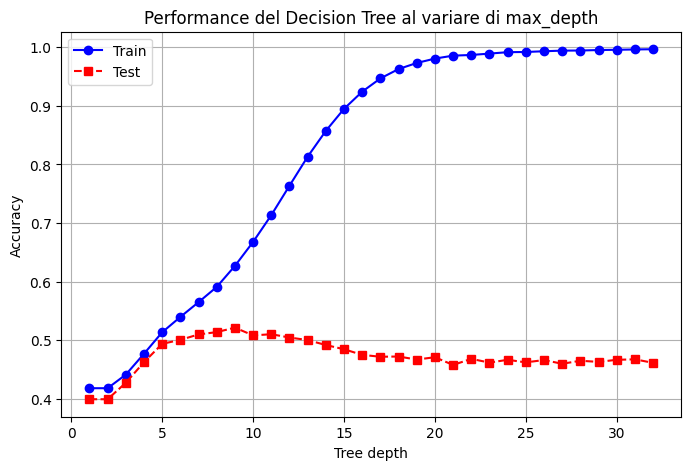

In [29]:
# Plot metrics accuracy
plt.figure(figsize=(8, 5))
plt.plot(max_depth_range, train_accuracies, marker='o', linestyle='-', label="Train", color='b')
plt.plot(max_depth_range, test_accuracies, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.title("Performance del Decision Tree al variare di max_depth")
plt.legend()
plt.grid()
plt.show()

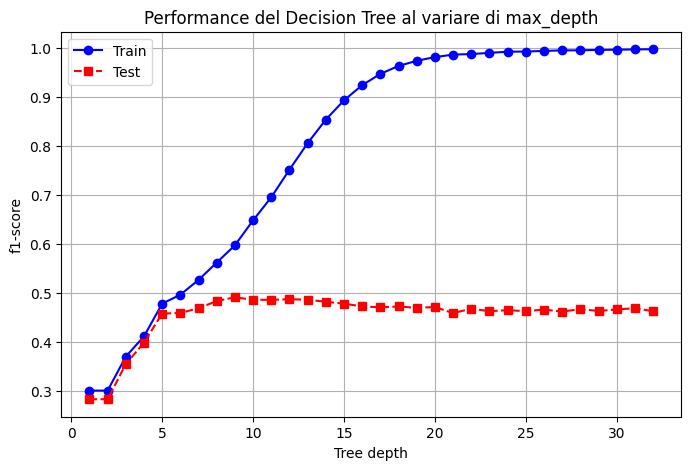

In [30]:
# Plot metrics f1-score
plt.figure(figsize=(8, 5))
plt.plot(max_depth_range, train_f1_scores, marker='o', linestyle='-', label="Train", color='b')
plt.plot(max_depth_range, test_f1_scores, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Tree depth")
plt.ylabel("f1-score")
plt.title("Performance del Decision Tree al variare di max_depth")
plt.legend()
plt.grid()
plt.show()

### Learn min_samples_split

In [31]:
X_train, X_test = X_trains[1], X_tests[1]
min_samples_split_range = np.linspace(0.01, 1.0, 20, endpoint=True)

# Liste per raccogliere le metriche
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

# Loop per testare diversi valori di min_samples_split
for min_samples_split in min_samples_split_range:
    model = tree.DecisionTreeClassifier(max_depth=best_max_depth, criterion='gini', splitter='best', min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    train_accuracies.append(acc_train)
    train_f1_scores.append(f1_train)
    test_accuracies.append(acc_test)
    test_f1_scores.append(f1_test)

    print(f"min_sample_split={min_samples_split}: Accuracy={acc_test:.4f}, F1_weighted={f1_test:.4f}")

min_sample_split=0.01: Accuracy=0.4956, F1_weighted=0.4606
min_sample_split=0.06210526315789474: Accuracy=0.4784, F1_weighted=0.4199
min_sample_split=0.11421052631578947: Accuracy=0.4460, F1_weighted=0.3469
min_sample_split=0.16631578947368422: Accuracy=0.4456, F1_weighted=0.3542
min_sample_split=0.21842105263157896: Accuracy=0.4456, F1_weighted=0.3542
min_sample_split=0.2705263157894737: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.32263157894736844: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.37473684210526315: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.4268421052631579: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.4789473684210527: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.5310526315789474: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.5831578947368421: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.6352631578947369: Accuracy=0.4183, F1_weighted=0.3266
min_sample_split=0.6873684210526316: Accuracy=0.4183, F1_we

In [33]:
# find the best min samples split
best_min_samples_split = min_samples_split_range[np.argmax(test_accuracies)]
print(f'Best min samples split: {best_min_samples_split}')
print(f'Best accuracy: {max(test_accuracies)}')

Best min samples split: 0.01
Best accuracy: 0.4955964771817454


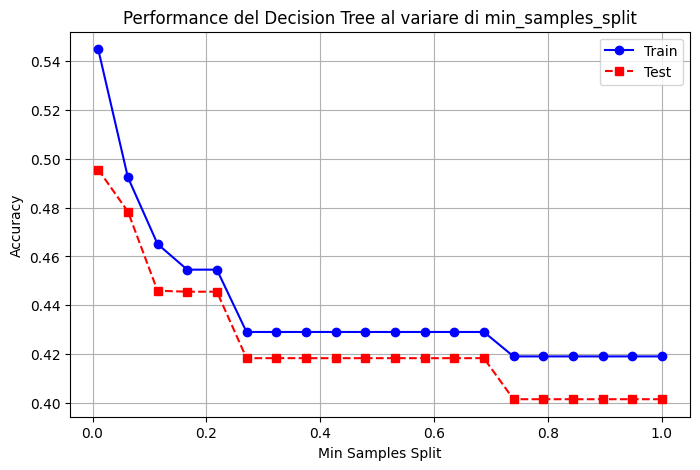

In [34]:
# Plot metrics accuracy
plt.figure(figsize=(8, 5))
plt.plot(min_samples_split_range, train_accuracies, marker='o', linestyle='-', label="Train", color='b')
plt.plot(min_samples_split_range, test_accuracies, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy")
plt.title("Performance del Decision Tree al variare di min_samples_split")
plt.legend()
plt.grid()
plt.show()

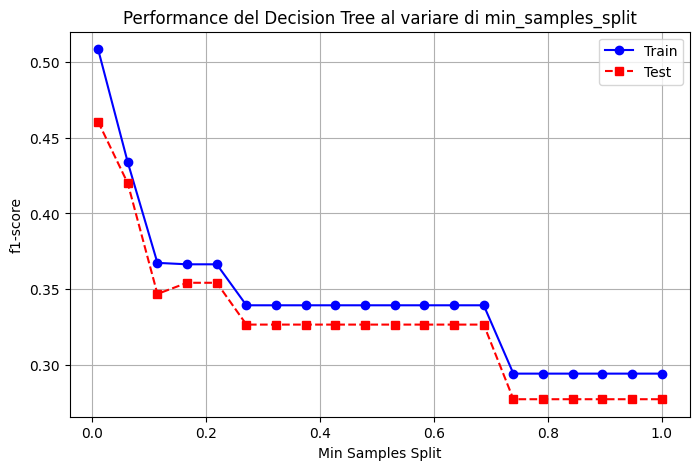

In [35]:
# Plot metrics f1-score
plt.figure(figsize=(8, 5))
plt.plot(min_samples_split_range, train_f1_scores, marker='o', linestyle='-', label="Train", color='b')
plt.plot(min_samples_split_range, test_f1_scores, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Min Samples Split")
plt.ylabel("f1-score")
plt.title("Performance del Decision Tree al variare di min_samples_split")
plt.legend()
plt.grid()
plt.show()

### min_samples_leaf

In [43]:
X_train, X_test = X_new_train, X_new_test
min_samples_leaf_range = [1, 5, 10, 15, 20]

# Liste per raccogliere le metriche
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

# Loop per testare diversi valori di min_samples_split
for min_samples_leaf in min_samples_leaf_range:
    model = tree.DecisionTreeClassifier(max_depth=best_max_depth, criterion='gini', splitter='best', min_samples_split=best_min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    train_accuracies.append(acc_train)
    train_f1_scores.append(f1_train)
    test_accuracies.append(acc_test)
    test_f1_scores.append(f1_test)

    print(f"min_sample_leaf={min_samples_leaf}: Accuracy={acc_test:.4f}, F1_weighted={f1_test:.4f}")

min_sample_leaf=1: Accuracy=0.5156, F1_weighted=0.4788
min_sample_leaf=5: Accuracy=0.5152, F1_weighted=0.4785
min_sample_leaf=10: Accuracy=0.5164, F1_weighted=0.4796
min_sample_leaf=15: Accuracy=0.5140, F1_weighted=0.4762
min_sample_leaf=20: Accuracy=0.5128, F1_weighted=0.4738


In [44]:
# find the best min samples split
best_min_samples_leaf = min_samples_leaf_range[np.argmax(test_accuracies)]
print(f'Best min samples split: {best_min_samples_leaf}')
print(f'Best accuracy: {max(test_accuracies)}')

Best min samples split: 10
Best accuracy: 0.5164131305044035


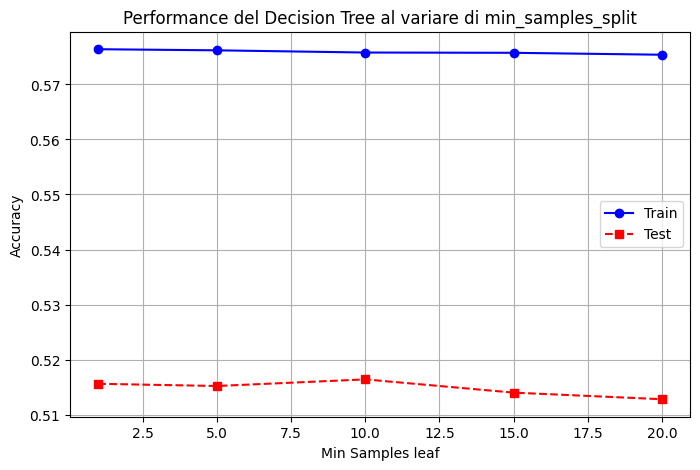

In [45]:
# Plot metrics accuracy
plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_range, train_accuracies, marker='o', linestyle='-', label="Train", color='b')
plt.plot(min_samples_leaf_range, test_accuracies, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Min Samples leaf")
plt.ylabel("Accuracy")
plt.title("Performance del Decision Tree al variare di min_samples_split")
plt.legend()
plt.grid()
plt.show()

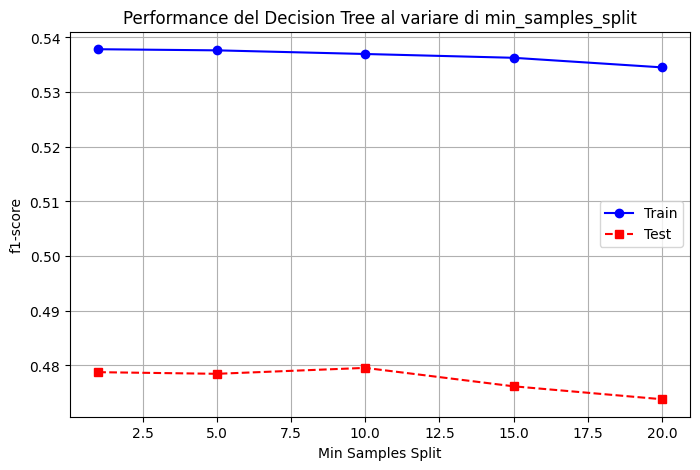

In [46]:
# Plot metrics f1-score
plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_range, train_f1_scores, marker='o', linestyle='-', label="Train", color='b')
plt.plot(min_samples_leaf_range, test_f1_scores, marker='s', linestyle='--', label="Test", color='r')

plt.xlabel("Min Samples Split")
plt.ylabel("f1-score")
plt.title("Performance del Decision Tree al variare di min_samples_split")
plt.legend()
plt.grid()
plt.show()

### GridSearchCV decision tree

In [ ]:
X_train, X_test = X_train[1], X_test[1]

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.linspace(1, 32, 32, endpoint=True).astype(int),
    'min_samples_split': np.linspace(0.01, 1.0, 20, endpoint=True),
    #'min_samples_leaf': [1, 2, 4]
}

model = tree.DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

## Bagging

La configurazione dei parametri che proponiamo è la seguente:
- *max_depth* = 1
- *n_estimators* = 8 (Numero di aberi)

Così, otteniamo i risultati in basso

In [ ]:
n_est = 8
md = 1


def bagging_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 1, title: str = 'Bagging'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = BaggingClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
bagging_clf(X_trains[0], y_train, X_tests[0], y_test, n_est = n_est, md = md, title = 'Bagging Original')

In [ ]:
bagging_clf(X_trains[1], y_train, X_tests[1], y_test, n_est = n_est, md = md, title = 'Bagging Reduced 90%')

In [ ]:
bagging_clf(X_trains[2], y_train, X_tests[2], y_test, n_est = n_est, md = md, title = 'Bagging Reduced 75%')

Esploriamo ora le performance del bagging facendo variare i meta-parametri, nello specifico:
- *max_depth* $\in$ [5, 10, 20, 30, 40] 
- *n_estimators* $\in$ [1,3, 5, 10, None]

In [ ]:
X_train, X_test = X_trains[1], X_tests[1]
n_trees_values = [5, 10, 20, 30, 40]  # Numero di alberi nel bagging
max_depth_values = [1,3, 5, 10, None]  # Profondità degli alberi (None = senza limite)

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))

# Loop su entrambi i parametri
for i, n_trees in enumerate(n_trees_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = BaggingClassifier(estimator=base_tree, n_estimators=n_trees, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_trees={n_trees}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_trees")

sns.heatmap(f1_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_trees")

plt.tight_layout()
plt.show()

## Random forest

Qui proponiamo una configurazione iniziale con 100 alberi di altezza al più 3. Seguono i risultati.

In [38]:
n_est = 100

def rnd_forest_clf(X_train, y_train, X_test, y_test, n_est = 100, title: str = 'Random forest'):

    # create the model
    model = RandomForestClassifier(n_estimators=n_est,max_depth=3)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
rnd_forest_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=n_est, title = "Random forest Original")

In [ ]:
rnd_forest_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=n_est, title = "Random forest Reduced 90%")

In [ ]:
rnd_forest_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=n_est, title = "Random forest Reduced 75%")

Come si può vedere dalla matrice sopra, le classi *Electronic* e *Rock* sono abbastanza patologiche, crediamo che questo comportamento sia dovuto all'eccessivo sbilanciamento del dataset. Ora esploriamo le performance del modello al variare di *n_trees_values* $\in$ [5, 10, 50, 100, 200, 500].

In [39]:
X_train, X_test = X_trains[1], X_tests[1]
n_trees_values = range(100, 1000, 50)

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su n_trees
for n_trees in n_trees_values:
    model = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"n_trees={n_trees}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

n_trees=100: Accuracy=0.4215, F1_weighted=0.2903
n_trees=150: Accuracy=0.4211, F1_weighted=0.2908
n_trees=200: Accuracy=0.4223, F1_weighted=0.2917
n_trees=250: Accuracy=0.4239, F1_weighted=0.2932
n_trees=300: Accuracy=0.4239, F1_weighted=0.2936
n_trees=350: Accuracy=0.4255, F1_weighted=0.2954
n_trees=400: Accuracy=0.4255, F1_weighted=0.2954
n_trees=450: Accuracy=0.4271, F1_weighted=0.2969
n_trees=500: Accuracy=0.4287, F1_weighted=0.2989
n_trees=550: Accuracy=0.4291, F1_weighted=0.2986
n_trees=600: Accuracy=0.4299, F1_weighted=0.2998
n_trees=650: Accuracy=0.4291, F1_weighted=0.2995
n_trees=700: Accuracy=0.4279, F1_weighted=0.2985
n_trees=750: Accuracy=0.4287, F1_weighted=0.2995
n_trees=800: Accuracy=0.4287, F1_weighted=0.2992
n_trees=850: Accuracy=0.4287, F1_weighted=0.2992
n_trees=900: Accuracy=0.4279, F1_weighted=0.2983
n_trees=950: Accuracy=0.4287, F1_weighted=0.2992


NameError: name 'n_estimators_range' is not defined

In [ ]:
best_n_estimator = n_trees_values[np.argmax(accuracy_values)]
print(f'Best n estimator: {best_n_estimator}')
print(f'Best accuracy: {max(accuracy_values)}')

In [ ]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(n_trees_values, accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(n_trees_values, f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Alberi (n_estimators)")
plt.ylabel("Score")
plt.title("Performance di Random Forest al variare di n_trees")
plt.legend()
plt.grid(True)
plt.show()

## AdaBoost

In modo simile ai modelli precedenti, qui proponiamo una configurazione dei parametri con 8 alberi dalla altezza al più pari a 2.

In [ ]:
n_est = 8
md = 2

def ada_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 2, title: str = 'Random forest'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = AdaBoostClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
ada_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=n_est, md=md, title = "Adaboost Original")

In [ ]:
ada_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=n_est, md=md, title = "Adaboost Reduced 90%")

In [ ]:
ada_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=n_est, md=md, title = "Adaboost Reduced 75%")

Facciamo ora variare il numero di alberi in [10, 50, 100, 150, 200] e la *max_depth* in [1, 2, 3, 5, 10].

In [ ]:
X_train, X_test = X_trains[1], X_tests[1]
n_estimators_values = [10, 50, 100, 150, 200]  # Numero di stadi del boosting
max_depth_values = [1, 2, 3, 5, 10]  # Profondità degli alberi base

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))

# Loop su entrambi i parametri
for i, n_estimators in enumerate(n_estimators_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = AdaBoostClassifier(estimator=base_tree, n_estimators=n_estimators, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_estimators={n_estimators}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_estimators")

sns.heatmap(f1_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_estimators")

plt.tight_layout()
plt.show()

## Extreme Gradient Boosting
XGB è un modello basato su alberi e consigliabile per classificazioni multiclasse.
Inoltre fa uso di alberi piccoli che ne migliorano la generalizzazione.

A differenza di AdaBoost, gli algoritmi di gradient boosting costruiscono classificatori deboli che sono dipendenti l'uno dall'altro. Ogni nuovo classificatore cerca di correggere gli errori residui fatti dai modelli precedenti.

In [36]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

def XGB(X_train, y_train, X_test, y_test, title: str = 'Extreme Gradient Boosting'):

    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_train_encoded = label_encoder.fit_transform(y_train)

    model = XGBClassifier()

    model.fit(X_train, y_train_encoded)

    valuate(model, X_test, y_test_encoded, title=title)


In [ ]:
XGB(X_trains[0], y_train, X_tests[0], y_test, title="XGB Original")

In [ ]:
XGB(X_trains[1], y_train, X_tests[1], y_test, title="XGB Reduced 90%")

In [ ]:
XGB(X_trains[2], y_train, X_tests[2], y_test, title="XGB Reduced 75%")

In [37]:
X_train, X_test = X_trains[1], X_tests[1]

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 1000, 50)
}

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

model = XGBClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train_encoded)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test_encoded)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'learning_rate': 0.1, 'n_estimators': 950}
Accuracy del modello ottimizzato: 0.6625300240192153


# Rete Neurale 

La rete neurale è un modello molto complesso che abbiamo soltanto introdotto durante il corso. Qui proponiamo un'architettura a tre layer, con solo uno hidden, il quale è munito di funzione di attivazione ReLu.

In [31]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y

In [ ]:
# Feedforward neural network
X_train, X_test = X_trains[1], X_tests[1]
d = 149

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(d, d//2)
        self.act = nn.ReLU()
        self.output = nn.Linear(d//2, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

y_train_tensor.shape

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 15
batch_size = 200
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)


In [ ]:
# Creazione della figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot della Loss
axes[0].plot(train_loss_hist, marker='o', linestyle='-', label="Train Loss", color="blue")
axes[0].plot(test_loss_hist, marker='s', linestyle='--', label="Test Loss", color="red")
axes[0].set_xlabel("Epoche")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_title("Andamento della Loss")
axes[0].legend()
axes[0].grid(True)

# Plot dell'Accuracy
axes[1].plot(train_acc_hist, marker='o', linestyle='-', label="Train Accuracy", color="blue")
axes[1].plot(test_acc_hist, marker='s', linestyle='--', label="Test Accuracy", color="red")
axes[1].set_xlabel("Epoche")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Andamento dell'Accuracy")
axes[1].legend()
axes[1].grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

Si può vedere che dalle epoche 6-8 il miglioramento della *Test loss* rallenta, fino ad appiattirsi e ad iniziare ad invertire il trend dall'epoca 14 (Qui non viene mostrato, ma se aumentiamo il numero di epoche a 30 si vede chiaramente che la *Test loss* aumenta dall'espoca 14-15 in poi), evidenziando il fenomeno dell'*overfitting*. Anche il secondo grafico supporta l'ipotesi appena avanzata, infatti è evidente un chiaro "rallentamento" del miglioramento dell'accuracy a partire dalla epoca 6.   

Per questo modello, visto l'altissimo numero di parametri, non abbiamo proposto nessun tipo di ricerca sul loro spazio. 

# GDA: Gaussian Discriminant Classifier

In [ ]:
def lda(X_train, y_train, X_test, y_test, title: str = 'LDA'):

    # create the model
    model = LinearDiscriminantAnalysis()

    # train the model
    model.fit(X_train, y_train)
    
    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
lda(X_trains[0], y_train, X_tests[0], y_test, title='LDA Original')

In [ ]:
lda(X_trains[1], y_train, X_tests[1], y_test, title='LDA reduced 90%')

In [ ]:
lda(X_trains[2], y_train, X_tests[2], y_test, title='LDA reduced 75%')

# kNN: k-Nearest-Neighbors

Qui, vista la presenza di un solo iper-parametro, ci limitiamo ad analizzare le performance dell'algoritmo al caso *k* $\in$ [1, 3, 5, 7, 9, 15, 25, 50] e plottiamo i risultati.

In [21]:
hyperparameters = {
    'n_neighbors': range(3,50,1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

### n_neighbors

In [22]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su k
for k in hyperparameters['n_neighbors']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"k={k}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

k=3: Accuracy=0.5937, F1_weighted=0.5805
k=4: Accuracy=0.5789, F1_weighted=0.5635
k=5: Accuracy=0.5905, F1_weighted=0.5719
k=6: Accuracy=0.5941, F1_weighted=0.5734
k=7: Accuracy=0.5953, F1_weighted=0.5695
k=8: Accuracy=0.5993, F1_weighted=0.5730
k=9: Accuracy=0.5937, F1_weighted=0.5655
k=10: Accuracy=0.5989, F1_weighted=0.5694
k=11: Accuracy=0.5933, F1_weighted=0.5633
k=12: Accuracy=0.5917, F1_weighted=0.5601
k=13: Accuracy=0.5937, F1_weighted=0.5615
k=14: Accuracy=0.5913, F1_weighted=0.5579
k=15: Accuracy=0.5929, F1_weighted=0.5593
k=16: Accuracy=0.5973, F1_weighted=0.5627
k=17: Accuracy=0.5905, F1_weighted=0.5557
k=18: Accuracy=0.5925, F1_weighted=0.5574
k=19: Accuracy=0.5921, F1_weighted=0.5551
k=20: Accuracy=0.5901, F1_weighted=0.5536
k=21: Accuracy=0.5873, F1_weighted=0.5511
k=22: Accuracy=0.5845, F1_weighted=0.5480
k=23: Accuracy=0.5793, F1_weighted=0.5413
k=24: Accuracy=0.5785, F1_weighted=0.5392
k=25: Accuracy=0.5761, F1_weighted=0.5372
k=26: Accuracy=0.5729, F1_weighted=0.5320

In [23]:
# find the best n estimator
best_n_neighbors = hyperparameters['n_neighbors'][np.argmax(accuracy_values)]
print(f'Best n estimator: {best_n_neighbors}')
print(f'Best accuracy: {max(accuracy_values)}')


Best n estimator: 8
Best accuracy: 0.599279423538831


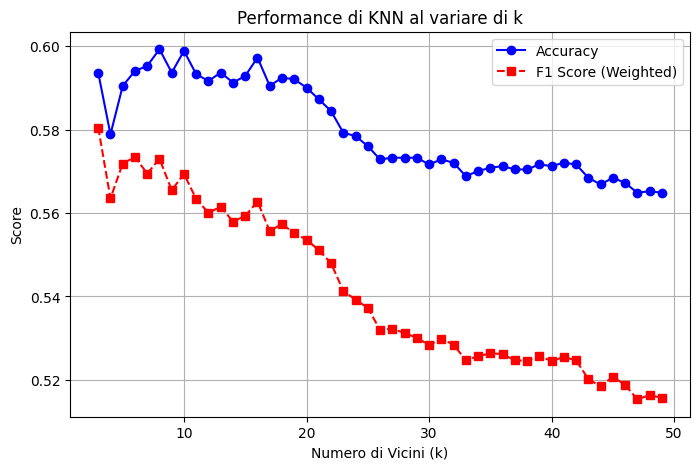

In [24]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['n_neighbors'], accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['n_neighbors'], f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Vicini (k)")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.grid(True)
plt.show()

### Weights

In [25]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su k
for k in hyperparameters['weights']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"k={k}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

k=uniform: Accuracy=0.5993, F1_weighted=0.5730
k=distance: Accuracy=0.2870, F1_weighted=0.3710


In [26]:
best_weights = hyperparameters['weights'][np.argmax(accuracy_values)]
print(f'Best n estimator: {best_weights}')
print(f'Best accuracy: {max(accuracy_values)}')

Best n estimator: uniform
Best accuracy: 0.599279423538831


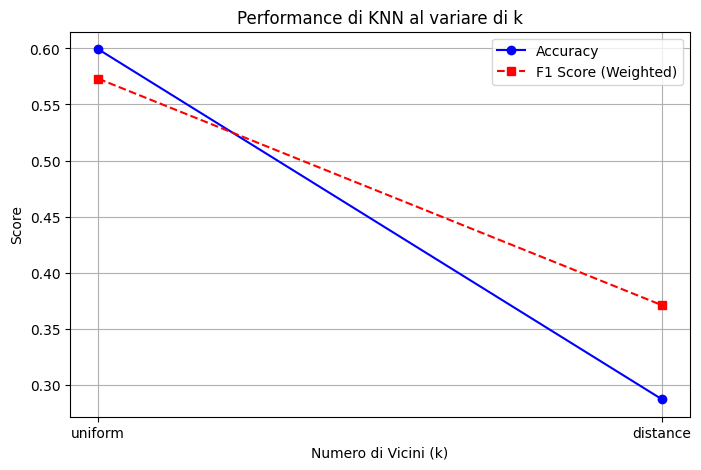

In [27]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['weights'], accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['weights'], f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Vicini (k)")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.grid(True)
plt.show()

### Metrica

In [28]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su k
for k in hyperparameters['metric']:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"k={k}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

k=euclidean: Accuracy=0.5993, F1_weighted=0.5730
k=manhattan: Accuracy=0.5861, F1_weighted=0.5601
k=chebyshev: Accuracy=0.5460, F1_weighted=0.5116
k=minkowski: Accuracy=0.5993, F1_weighted=0.5730


In [29]:
best_metric = hyperparameters['metric'][np.argmax(accuracy_values)]
print(f'Best n estimator: {best_metric}')
print(f'Best accuracy: {max(accuracy_values)}')

Best n estimator: euclidean
Best accuracy: 0.599279423538831


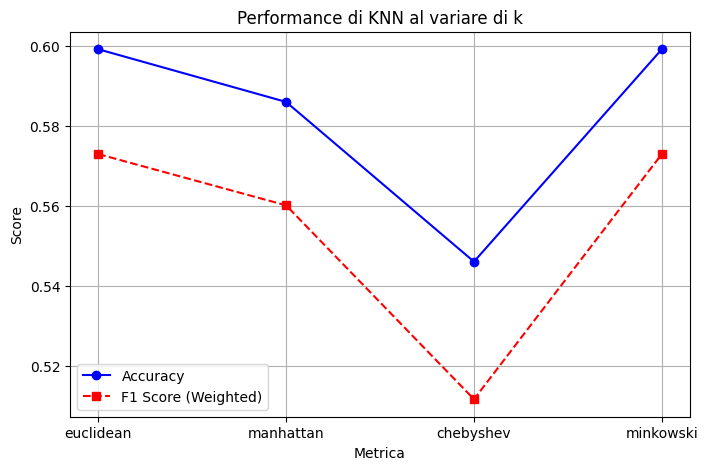

In [30]:
# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(hyperparameters['metric'], accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(hyperparameters['metric'], f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Metrica")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
model = sklearn.neighbors.KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5)

grid_search.fit(X_trains[1], y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_tests[1], y_test)
print(f'Migliori parametri: {best_params}')
print(f'Accuracy del modello ottimizzato: {accuracy}')

Migliori parametri: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
Accuracy del modello ottimizzato: 0.599279423538831


# Logistic Regression

In [14]:
# logistic regression
from sklearn.linear_model import LogisticRegression

def logistic_regression(X_train, y_train, X_test, y_test, C: float = 1.0, penalty: str = "l2", title: str = 'Logistic Regression'):
    # create the model
    model = LogisticRegression(max_iter=1000, C=C, penalty=penalty)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matrix
    valuate(model, X_test, y_test, title=title)


                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.66      0.78      0.71        77
            country       0.18      0.25      0.21        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.66      0.74      0.70       606
       experimental       0.46      0.37      0.41       226
               folk       0.62      0.59      0.60       152
            hip-hop       0.69      0.62      0.65       223
       instrumental       0.40      0.38      0.39       137
      international       0.53      0.52      0.52       104
               jazz       0.31      0.41      0.36        41
old-time / historic       0.90      0.98      0.94        45
                pop       0.26      0.10      0.15       126
               rock       0.74      0.79      0.76       699
           soul-rnb       0.03      0.05      0.04        19
             spoken    

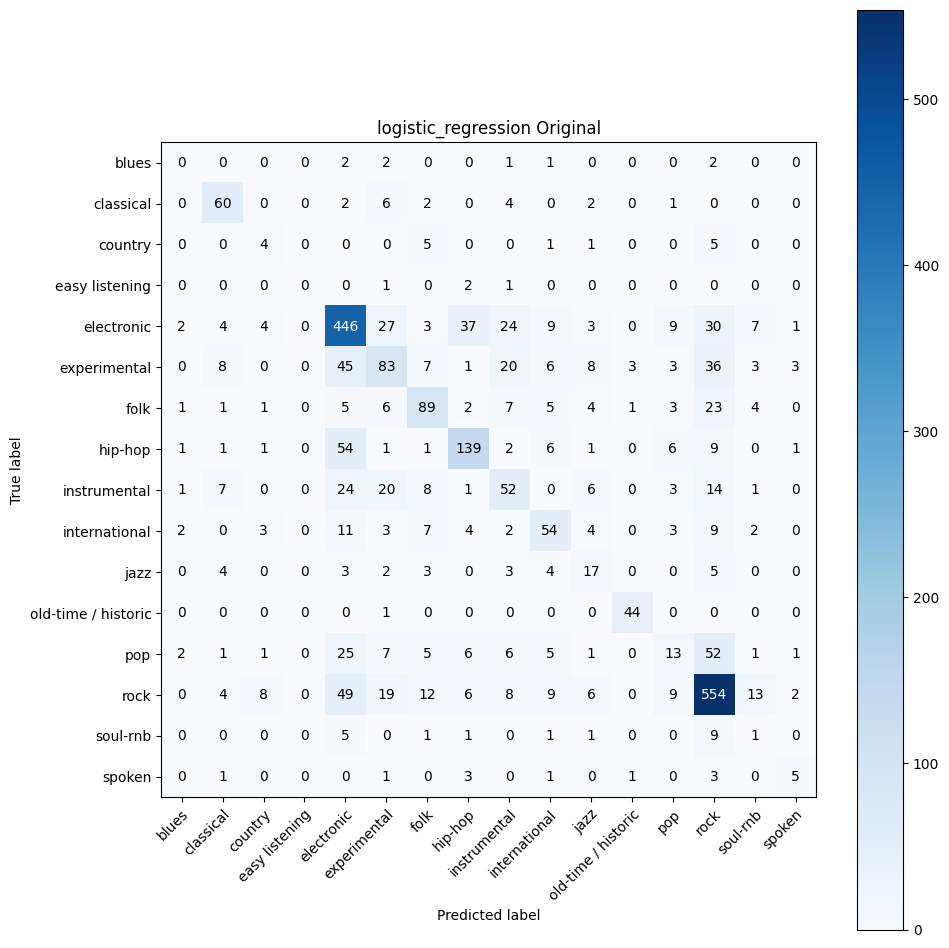

In [15]:
logistic_regression(X_trains[0], y_train, X_tests[0], y_test, title="logistic_regression Original")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.73      0.90      0.81        77
            country       0.17      0.06      0.09        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.65      0.77      0.70       606
       experimental       0.54      0.37      0.44       226
               folk       0.58      0.58      0.58       152
            hip-hop       0.65      0.61      0.63       223
       instrumental       0.45      0.36      0.40       137
      international       0.48      0.40      0.44       104
               jazz       0.47      0.41      0.44        41
old-time / historic       0.78      0.93      0.85        45
                pop       0.30      0.05      0.08       126
               rock       0.71      0.84      0.77       699
           soul-rnb       0.11      0.05      0.07        19
             spoken    

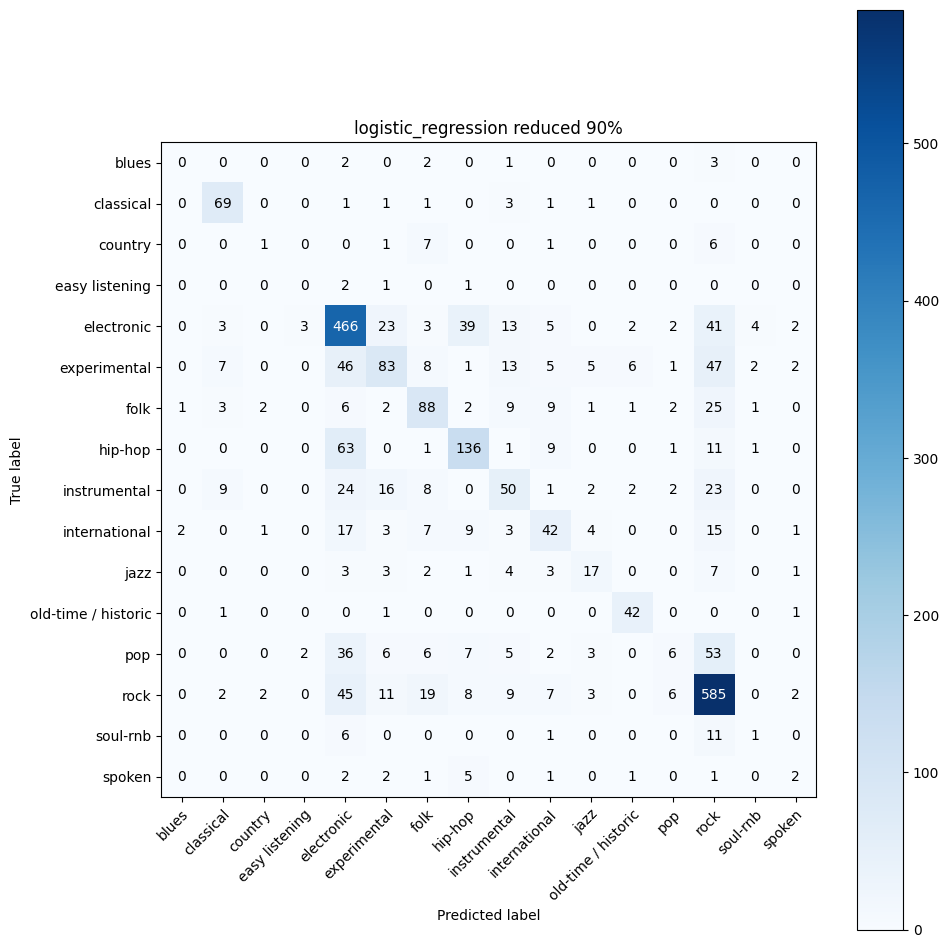

In [16]:
logistic_regression(X_trains[1], y_train, X_tests[1], y_test, title="logistic_regression reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00         8
          classical       0.73      0.83      0.78        77
            country       0.20      0.06      0.10        16
     easy listening       0.00      0.00      0.00         4
         electronic       0.62      0.77      0.68       606
       experimental       0.51      0.34      0.41       226
               folk       0.51      0.58      0.54       152
            hip-hop       0.61      0.57      0.59       223
       instrumental       0.39      0.28      0.32       137
      international       0.49      0.34      0.40       104
               jazz       0.38      0.27      0.31        41
old-time / historic       0.86      0.96      0.91        45
                pop       0.20      0.02      0.03       126
               rock       0.70      0.85      0.77       699
           soul-rnb       0.50      0.05      0.10        19
             spoken    

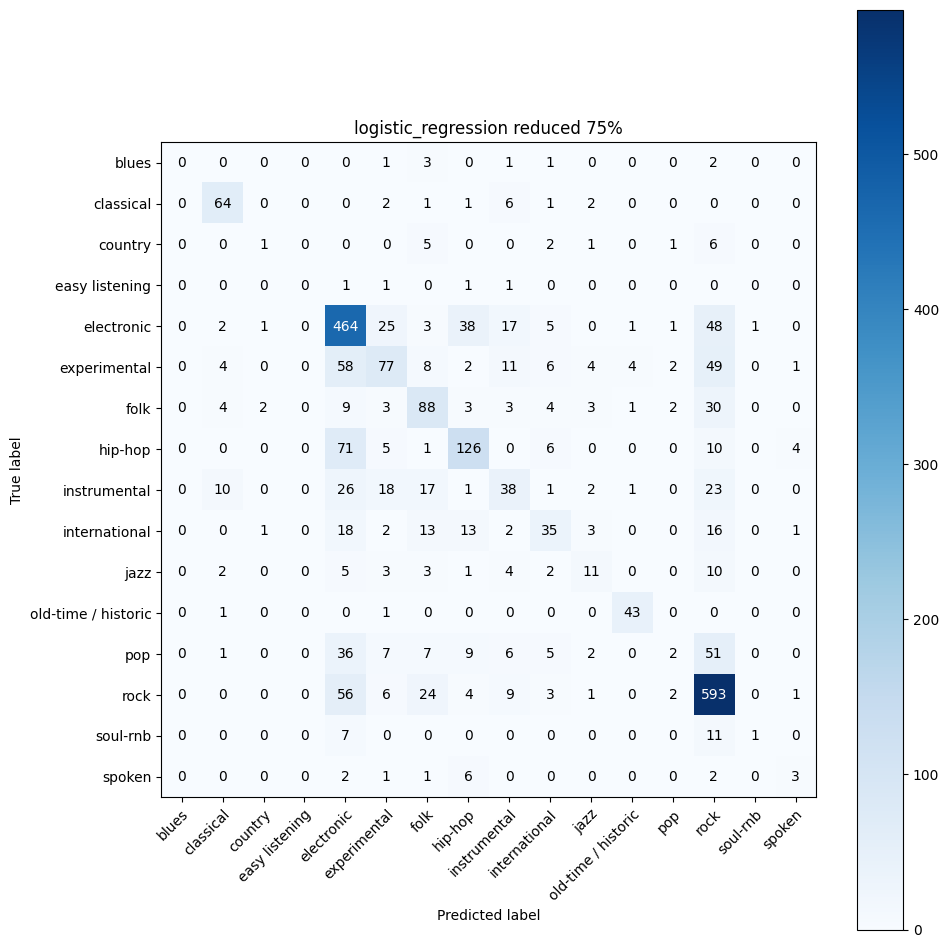

In [17]:
logistic_regression(X_trains[2], y_train, X_tests[2], y_test, title="logistic_regression reduced 75%")

In [29]:
# hyperparameter C tuning
c_range = np.linspace(5.9,6,100)

In [30]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per raccogliere le metriche
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

# Loop per testare diversi valori di min_samples_split
for c in c_range:
    model = LogisticRegression(max_iter=1000, C=c, penalty='l2', n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    train_accuracies.append(acc_train)
    train_f1_scores.append(f1_train)
    test_accuracies.append(acc_test)
    test_f1_scores.append(f1_test)

    print(f"c={c}: Accuracy={acc_test:.4f}, F1_weighted={f1_test:.4f}")

c=5.9: Accuracy=0.6249, F1_weighted=0.6036
c=5.901010101010101: Accuracy=0.6405, F1_weighted=0.6141
c=5.902020202020203: Accuracy=0.6413, F1_weighted=0.6144
c=5.903030303030303: Accuracy=0.6373, F1_weighted=0.6102
c=5.904040404040404: Accuracy=0.6193, F1_weighted=0.5980
c=5.9050505050505055: Accuracy=0.6413, F1_weighted=0.6145
c=5.906060606060606: Accuracy=0.6305, F1_weighted=0.6040
c=5.907070707070708: Accuracy=0.6377, F1_weighted=0.6108
c=5.9080808080808085: Accuracy=0.6421, F1_weighted=0.6149
c=5.909090909090909: Accuracy=0.6321, F1_weighted=0.6063
c=5.910101010101011: Accuracy=0.6397, F1_weighted=0.6136
c=5.911111111111111: Accuracy=0.6017, F1_weighted=0.5705
c=5.912121212121212: Accuracy=0.6321, F1_weighted=0.6052
c=5.913131313131314: Accuracy=0.6285, F1_weighted=0.6065
c=5.914141414141414: Accuracy=0.6397, F1_weighted=0.6130
c=5.915151515151515: Accuracy=0.6317, F1_weighted=0.6035
c=5.916161616161617: Accuracy=0.6269, F1_weighted=0.6020
c=5.917171717171717: Accuracy=0.6301, F1_we

In [31]:
best_c = c_range[np.argmax(test_accuracies)]
print(f'Best c: {best_c}')
print(f'Best accuracy: {max(test_accuracies)}')

Best c: 5.931313131313131
Best accuracy: 0.6425140112089672


### Learn best penalty

In [32]:
# hyperparameter penalty tuning
penalty_range = [None, 'l2']

In [33]:
X_train, X_test = X_trains[1], X_tests[1]

# Liste per raccogliere le metriche
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

# Loop per testare diversi valori di min_samples_split
for penalty in penalty_range:
    model = LogisticRegression(max_iter=1000, C=best_c, penalty=penalty)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    
    acc_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    train_accuracies.append(acc_train)
    train_f1_scores.append(f1_train)
    test_accuracies.append(acc_test)
    test_f1_scores.append(f1_test)

    print(f"penalty={penalty}: Accuracy={acc_test:.4f}, F1_weighted={f1_test:.4f}")

penalty=None: Accuracy=0.6357, F1_weighted=0.6094
penalty=l2: Accuracy=0.6357, F1_weighted=0.6101


In [34]:
best_penalty = penalty_range[np.argmax(test_accuracies)]
print(f'Best penalty: {best_penalty}')
print(f'Best accuracy: {max(test_accuracies)}')


Best penalty: None
Best accuracy: 0.6357085668534828


# Conclusioni

In questo studio, abbiamo analizzato e confrontato diversi algoritmi di classificazione per il nostro dataset: 
- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**

L'obiettivo era valutare le loro prestazioni utilizzando diverse metriche, tra cui accuratezza, F1-score e matrice di confusione. Ogni algoritmo è stato eseguito per un valore fissato degli iperparametri, facendo variare il numero di feature, mostrando prima i risultati per le feature che spiegano il 75% della varianza, poi il 90% e infine il 100%. I risultati che abbiamo ottenuto mostrano che ottime performance si ottengono già con il 75% della varianza, con il 90% si ottiene un miglioramento non trascurabile mentre il salto a 100% offre miglioramenti abbastanza marginali. Osserviamo che questi ragionamenti si applicano a tutte le classi di modelli su cui abbiamo fatto questi test eccetto quelli delle famiglie **Arboree**(Decision Tree, Bagging, Boosting), questo perchè è evidente che il set di iperparametri che abbiamo scelto non era affatto ottimale, spesso questi tendono all'underfitting. Questa nostra ipotesi è supportata anche dai test che abbiamo fatto sul dataset con il 90% della varianza e facendo variare gli iperparametri, infatti, se osserviamo i grafici dei modelli di questa famiglia, si vede che all'aumentare dei valori degli iperparametri si ottengono performance sempre migliori, fino ad ottenere risultati comparabili con quelli degli altri modelli che abbiamo testato. 

## Metodologia

Abbiamo iniziato con la preparazione del dataset, includendo la normalizzazione e la selezione delle feature più rilevanti tramite PCA. Successivamente, abbiamo addestrato e testato ogni modello utilizzando tre diverse suddivisioni train-test (75%, 90% e 100% della varianza) e, per tutti i modelli eccetto Multilayer Perceptron, abbiamo esplorato diversi valori degli iperparametri per ottimizzare le performance.

## Limitazioni e sviluppi futuri

Questo studio presenta alcune limitazioni che potrebbero influenzare i risultati ottenuti:

- **Rappresentazione dei dati**: Non abbiamo utilizzato tecniche avanzate come autoencoder o altre forme di apprendimento non supervisionato per l'estrazione automatica delle feature, ma ci siamo limitati alle feature estratte con dei software di *Audio Signal Processing*.

- **Dataset sbilanciato**: L'analisi è stata condotta su un dataset fortemente sbilanciato, il che ha influenzato le prestazioni dei modelli e la capacità di generalizzazione, favorendo le classi più rappresentate.

- **Modelli non deep**: Tutti i modelli utilizzati appartengono alla famiglia del machine learning tradizionale e non abbiamo esplorato approcci deep learning, che potrebbero offrire prestazioni superiori in determinati contesti.

Ulteriori miglioramenti potrebbero essere ottenuti con tecniche di selezione delle feature più avanzate o con l'uso di modelli più sofisticati, come gli autoencoder (con RNN). Un'analisi più approfondita sull'importanza delle feature potrebbe anche fornire indicazioni utili per migliorare la classificazione.

In futuro, sarebbe interessante sperimentare con set di dati più ampi e diversificati, oltre a integrare tecniche di ottimizzazione iperparametrica per migliorare ulteriormente le performance dei modelli testati.